In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display
import librosa.display
import numpy as np
import librosa
import tensorflow as tf
import glob

In [2]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools as it

In [3]:
# Declare Variables
n_mfcc = 16
n_frame = 16
n_classes = 3
n_channels = 1
learning_rate = 0.0002  # 0.005

In [4]:
def run_train(session, train_x, train_y):
    print ("\nStart training")
    session.run(init)
    for epoch in range(10):
        total_batch = int(train_x.shape[0] / batch_size)
        for i in range(total_batch):
            batch_x = train_x[i*batch_size:(i+1)*batch_size]
            batch_y = train_y[i*batch_size:(i+1)*batch_size]
            _, c = session.run([optimizer, cost], feed_dict={X: batch_x, Y: batch_y})
            if i % 100 == 0:
                print ("Epoch #%d step=%d cost=%f" % (epoch, i, c))

In [5]:
def cross_validate(session, split_size=5):
    results = []
    kf = KFold(n_splits=split_size)
    for train_idx, val_idx in kf.split(X_train2, y_train):
        train_x = X_train2[train_idx]
        train_y = y_train[train_idx]
        val_x = X_train2[val_idx]
        val_y = y_train[val_idx]
        run_train(session, train_x, train_y)
        y_true = session.run(tf.argmax(val_y,1))
        y_pred = session.run(tf.argmax(logits,1),feed_dict={X: val_x})
        from sklearn.metrics import accuracy_score
        results.append(accuracy_score(y_true, y_pred))
    return results

In [6]:
### Data Loading ###
X_train = np.load('./X_train_chunk_3d.npy')
X_test = np.load('./X_test_chunk_3d.npy')
y_train = np.load('./y_train_chunk_3d.npy')
y_test = np.load('./y_test_chunk_3d.npy')

# Convolutional Layer

In [7]:
tf.reset_default_graph()

In [8]:
X = tf.placeholder(tf.float32, shape=[None,n_mfcc*n_frame*n_channels])
X = tf.reshape(X, [-1, n_mfcc, n_frame, n_channels])
Y = tf.placeholder(tf.float32, shape=[None,n_classes])

conv1 = tf.layers.conv2d(inputs=X, filters=1, kernel_size=[3, 3],
                         padding="SAME", activation=tf.nn.relu)
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2],
                                padding="SAME", strides=1)

conv2 = tf.layers.conv2d(inputs=pool1, filters=1, kernel_size=[3, 3],
                         padding="SAME", activation=tf.nn.relu)
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2],
                                padding="SAME", strides=1)

flat = tf.reshape(pool2, [-1, 16*16*1])

In [9]:
dense2 = tf.layers.dense(inputs=flat, units=625, activation=tf.nn.relu)
logits = tf.layers.dense(inputs=dense2, units=3)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [10]:
X_train2 = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test2 = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

Y_pred = tf.contrib.layers.fully_connected(logits,n_classes,activation_fn = None)

In [11]:
init = tf.global_variables_initializer()
correct_prediction = tf.equal(tf.argmax(Y_pred, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [12]:
### Save Model ###
model_path = './cnnmodel'
saver = tf.train.Saver()

# Run Model

In [13]:
###########################
batch_size = 128
cost_history = np.empty(shape=[1], dtype=float)

with tf.Session() as session:
    result = cross_validate(session)
    print ("Cross-validation result: %s" % result)
    y_true = session.run(tf.argmax(y_train,1))
    y_pred = session.run(tf.argmax(logits,1),feed_dict={X: X_train2})
    from sklearn.metrics import accuracy_score
    print ("Test accuracy: %f" % accuracy_score(y_true, y_pred))
    saver.save(session, model_path)
    y_pred = session.run(tf.argmax(logits,1),feed_dict={X: X_test2})
    y_true = session.run(tf.argmax(y_test,1))


Start training
Epoch #0 step=0 cost=113.060822
Epoch #0 step=100 cost=1.360518
Epoch #0 step=200 cost=0.980379
Epoch #1 step=0 cost=0.897215
Epoch #1 step=100 cost=1.005286
Epoch #1 step=200 cost=0.633064
Epoch #2 step=0 cost=0.750815
Epoch #2 step=100 cost=0.866993
Epoch #2 step=200 cost=0.631383
Epoch #3 step=0 cost=0.591807
Epoch #3 step=100 cost=0.741926
Epoch #3 step=200 cost=0.603986
Epoch #4 step=0 cost=0.513372
Epoch #4 step=100 cost=0.631998
Epoch #4 step=200 cost=0.582623
Epoch #5 step=0 cost=0.474891
Epoch #5 step=100 cost=0.621600
Epoch #5 step=200 cost=0.575095
Epoch #6 step=0 cost=0.428352
Epoch #6 step=100 cost=0.489965
Epoch #6 step=200 cost=0.567231
Epoch #7 step=0 cost=0.415150
Epoch #7 step=100 cost=0.462093
Epoch #7 step=200 cost=0.488855
Epoch #8 step=0 cost=0.403689
Epoch #8 step=100 cost=0.433387
Epoch #8 step=200 cost=0.443367
Epoch #9 step=0 cost=0.416631
Epoch #9 step=100 cost=0.442747
Epoch #9 step=200 cost=0.388292

Start training
Epoch #0 step=0 cost=1.999

# Show  pred result of test set

F-Score: 0.815
Accuracy:  0.8146934955545156
             precision    recall  f1-score   support

          0       0.84      0.89      0.86      3141
          1       0.85      0.77      0.80      2975
          2       0.75      0.78      0.76      2432

avg / total       0.82      0.81      0.81      8548

[[2793  136  212]
 [ 279 2283  413]
 [ 262  282 1888]]


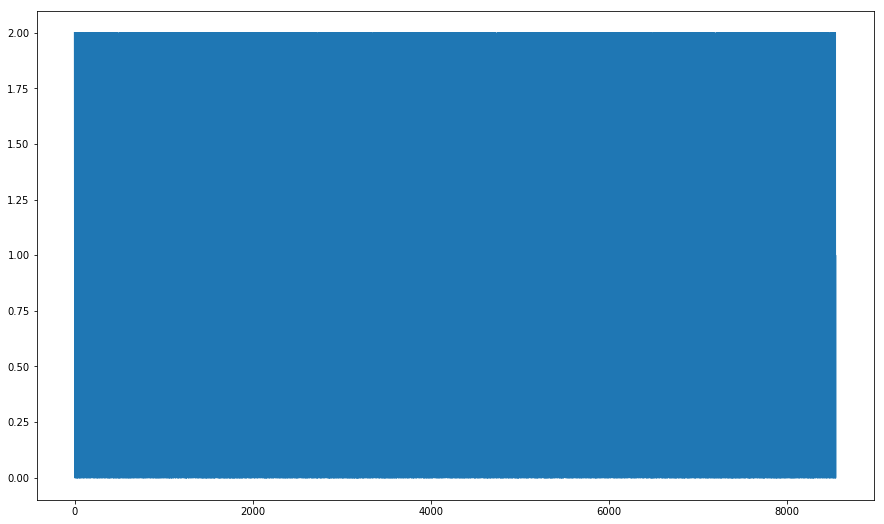

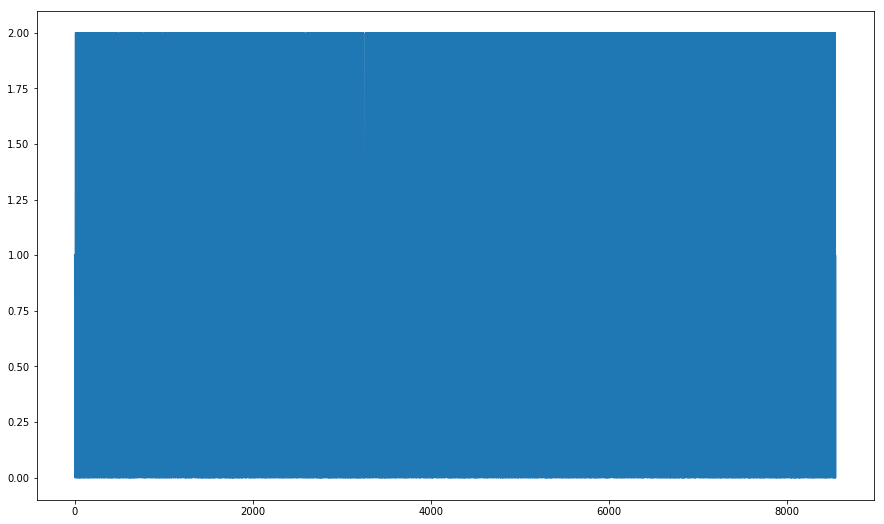

In [14]:
from sklearn.metrics import precision_recall_fscore_support
p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print("F-Score:", round(f,3))
from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(y_true, y_pred))

### print true graph###
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(1,1,1)
ax.plot(np.linspace(0,len(y_pred), len(y_pred)),y_true)

### print pred graph###
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(1,1,1)
ax.plot(np.linspace(0,len(y_pred), len(y_pred)),y_pred)

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))